- title: Pseudo online LSTM RNN
- author: Amol Kelkar
- date: 2018-10-01
- category: ai
- tags: keras, lstm, rnn, online learning

#### NOTE: Please see [updated blog post](./pseudo-online-lstm-rnn-revisited.html) for this project

I am building a new type of deep neural network based on predictive coding and free energy minimization. As one of the first steps, I need to set up an RNN building block that can be trained online by sending one training point $(X_t, y_t)$ at a time. Given the time-unwrapped nature of RNNs, they need each training sample to span several timesteps.

$(X_{sample}, y_{sample}) = (\{X_t\mid t\in[{t}_{min} \to {t}_{max}]\}, \{y_t\mid t\in[{t}_{min} \to {t}_{max}]\})$

Note: The $X_{sample}$ and $y_{sample}$ lengths need not be the same, but it is convenient for this case given we would receive a $(X_t, y_t)$ pair every time step.

Also, training in batches is a more optimal strategy, so we want samples to be collected in a batch.

$(X_{batch}, y_{batch}) = (\{X_{sample}^i\mid i\in[0 \to n_{batch}]\})$

To achieve this, we will use a sliding window of size $(t_{max} - t_{min})$ to make a sample and collect $n_{batch}$ such samples.

The result would be a way to feed data points one at a time while the RNN gets trained using accumulated batches of data.

## Generate sample time series data
As seen above, each training sample contains a time series fragment $X_{sample}$ and another time series fragment $y_{sample}$. So we are looking at time series to time series prediction. Here I am adopting time series data generation code from a [wonderful blog post](https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html) by Yumi.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)
    
set_seed(121)

def random_sample(len_ts=3000,D=10):
    c_range = range(5,100)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    
    y1 = np.zeros(len_ts)

    for t in range(D,len_ts):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2]*x1[t-D] 
    y = np.array([y1]).T
    X = np.array([x1]).T
    return X, y

def plot_sample(sample):
    if len(sample) == 2:
        (X, y) = sample
        y2 = None
    elif len(sample) == 3:
        (X, y, y2) = sample
    else:
        assert(False, 'Sample must be (X, y) or (X, y, y2)')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(-0.5,0.5)
    ax.plot(X[:,0],"--",label="X")
    ax.plot(y[:,0],label="y",linewidth=3,alpha = 0.5)
    if y2 is not None:
        ax.plot(y2[:,0],label="y_pred",linewidth=2,alpha = 0.5)

    ax.set_title("Sample time series data")
    plt.legend()
    plt.show()


Using TensorFlow backend.


python 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
keras version 2.2.2
tensorflow version 1.10.0


<Figure size 1000x600 with 1 Axes>

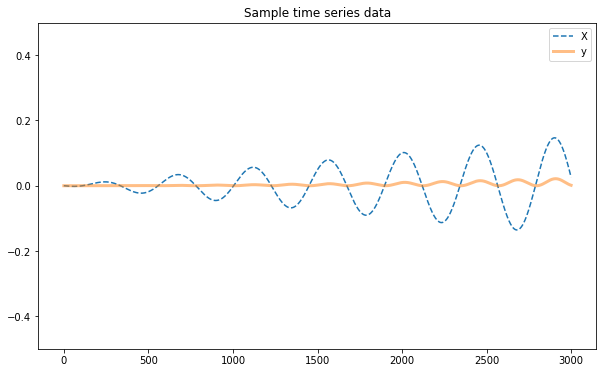

In [2]:
sample_data = random_sample()

plot_sample(sample_data)

Now we need a Python generator that spews out one data point at a time, internally calling random_sample() as needed. This would simulate a data stream.

In [2]:
class SampleDataPointsGenerator(object):
    def __init__(self, ts=3000):
        self.sample_data = None
        self.ts = ts
        self.index = 0
        
    def __next__(self):
        if self.sample_data == None or self.index == self.ts:
            self.sample_data = random_sample(len_ts = self.ts)
            self.index = 0
            
        retval = (self.sample_data[0][self.index], self.sample_data[1][self.index])
        self.index += 1
        return retval

Make sure points generator can produce more points than one sample's length.

In [3]:
points_generator = SampleDataPointsGenerator(3)
for _ in range(8):
    print(next(points_generator))

(array([-0.]), array([0.]))
(array([-0.05064316]), array([0.]))
(array([-0.10125619]), array([0.]))
(array([-0.]), array([0.]))
(array([-0.0251849]), array([0.]))
(array([-0.05034187]), array([0.]))
(array([-0.]), array([0.]))
(array([-0.24847105]), array([0.]))


## Collect batches of data points
Now let's create a class that would convert data points to batches and call `fit` or `predict` on a given model once a batch is ready.

First a sliding window buffer. Appending an item would push out an item from the left of the buffer, thus the buffer would always contain the last `item_count` items.

In [4]:
class SlidingWindowBuffer(object):
    def __init__(self, item_count, item_shape=(1)):
        self.item_shape = item_shape
        self.item_count = item_count
        self.buffer = []
        
    def append_item(self, item):
        # return None while gathering initial items
        if len(self.buffer) < self.item_count - 1:
            self.buffer.append(item)
            return None
        
        # once enough items, convert to np.array
        elif len(self.buffer) == self.item_count - 1:
            self.buffer.append(item)
            self.buffer = np.array(self.buffer)
            
        else:
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = item
            
        return self.buffer
        
buffer = SlidingWindowBuffer(item_count = 2, item_shape=(2, 2))
print(buffer.append_item(np.eye(2) + np.ones((2, 2)) * 1))
print(buffer.append_item(np.eye(2) + np.ones((2, 2)) * 2))
print(buffer.append_item(np.eye(2) + np.ones((2, 2)) * 3))
print(buffer.append_item(np.eye(2) + np.ones((2, 2)) * 4))

None
[[[2. 1.]
  [1. 2.]]

 [[3. 2.]
  [2. 3.]]]
[[[3. 2.]
  [2. 3.]]

 [[4. 3.]
  [3. 4.]]]
[[[4. 3.]
  [3. 4.]]

 [[5. 4.]
  [4. 5.]]]


Now the main logic. As a new point comes in, `OnlineToBatch` will add it to buffers, producing a new sample. Such samples would be collected into a batch. Once a batch is full, `fit` or `predict` would be called on the model with the batch, and a new batch would start getting accumulated.

In [5]:
class OnlineToBatch(object):
    def __init__(self, t_sample, n_batch, X_t_shape=(1,), y_t_shape=(1,)):
        self.t_sample = t_sample
        self.n_batch = n_batch
        self.X_t_shape = X_t_shape
        self.y_t_shape = y_t_shape

        self.X_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=X_t_shape)
        self.y_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=y_t_shape)

        self.reset_batch_buffer()
    
    def reset_batch_buffer(self):
        self.X_batch = []
        self.y_batch = []
        
    # add point to current batch
    # if batch is ready, make the action ('fit' or 'predict') on the model
    def process_point(self, model, X_point, y_point, epochs=1, verbose=2, action='fit'):
        X_sample = self.X_points_buffer.append_item(X_point)
        y_sample = self.y_points_buffer.append_item(y_point)

        if X_sample is not None:
            assert(y_sample is not None)
            self.X_batch.append(X_sample)
            self.y_batch.append(y_sample)
            
            if len(self.X_batch) == self.n_batch:
                assert(len(self.y_batch) == self.n_batch)
                
                X = np.array(self.X_batch)
                assert(X.shape == ((self.n_batch, self.t_sample) + self.X_t_shape))
                
                y = np.array(self.y_batch)
                assert(y.shape == ((self.n_batch, self.t_sample) + self.y_t_shape))

                if action == 'fit':
                    print('calling fit with X {0} and y {1}'.format(X.shape, y.shape))
                    results = model.fit(X, y, batch_size=self.n_batch, epochs=epochs, verbose=verbose)
                elif action == 'predict':
                    print('calling predict with X {0} and y {1}'.format(X.shape, y.shape))
                    results = model.predict(X)

                self.reset_batch_buffer()
                return results, X, y
        return None, None, None

class TestModel(object):
    def __init__(self):
        pass

    def fit(self, X, y, batch_size, epochs, verbose):
        print('X = \n{}'.format(np.matrix(X)))
        print('y = \n{}'.format(np.matrix(y)))
        print()
        
online_fit = OnlineToBatch(t_sample = 3, n_batch = 4)
model = TestModel()
for i in range(15):
    online_fit.process_point(model, [i], [i*i])
    print('---- {} ----'.format(i))

---- 0 ----
---- 1 ----
---- 2 ----
---- 3 ----
---- 4 ----
calling fit with X (4, 3, 1) and y (4, 3, 1)
X = 
[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]]
y = 
[[ 0  1  4]
 [ 1  4  9]
 [ 4  9 16]
 [ 9 16 25]]

---- 5 ----
---- 6 ----
---- 7 ----
---- 8 ----
calling fit with X (4, 3, 1) and y (4, 3, 1)
X = 
[[4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]
y = 
[[16 25 36]
 [25 36 49]
 [36 49 64]
 [49 64 81]]

---- 9 ----
---- 10 ----
---- 11 ----
---- 12 ----
calling fit with X (4, 3, 1) and y (4, 3, 1)
X = 
[[ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]]
y = 
[[ 64  81 100]
 [ 81 100 121]
 [100 121 144]
 [121 144 169]]

---- 13 ----
---- 14 ----


## Create LSTM based model
To test if `OnlineToBatch` can successfully drive the training of an model, we will create a LSTM based model.

In [6]:
from keras import models, layers

def define_model(t_sample,
                 hidden_neuron_count = 10,
                 X_t_shape=(1,),
                 batch_size=None):
    in_out_neurons = 1

    input_layer = layers.Input(batch_shape=(batch_size, t_sample) + X_t_shape, name="input")

    rnn = layers.LSTM(hidden_neuron_count,
                    return_sequences=True,
                    name="RNN")(input_layer)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[input_layer],outputs=[dens])

    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(input_layer,rnn,dens))

hidden_neuron_count = 64
X_t_shape = (1,)
y_t_shape = (1,)
t_sample = 900
model, _ = define_model(t_sample = t_sample, hidden_neuron_count = hidden_neuron_count, X_t_shape = X_t_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 900, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 900, 64)           16896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 900, 1)            65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Train model online by feeding a stream of points

Points are generated for multiple samples and fed into the model as a stream. Charts below show discontinuities where samples are joined.

calling fit with X (500, 900, 1) and y (500, 900, 1)


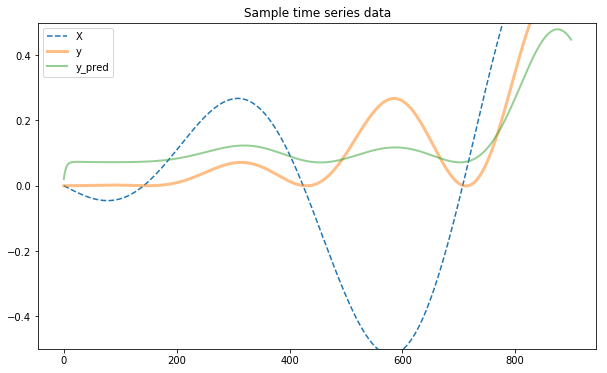

calling fit with X (500, 900, 1) and y (500, 900, 1)


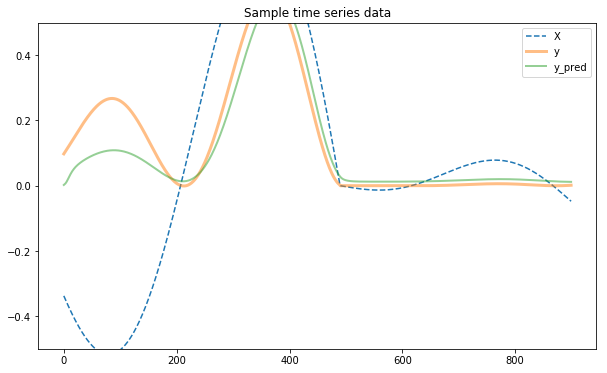

calling fit with X (500, 900, 1) and y (500, 900, 1)


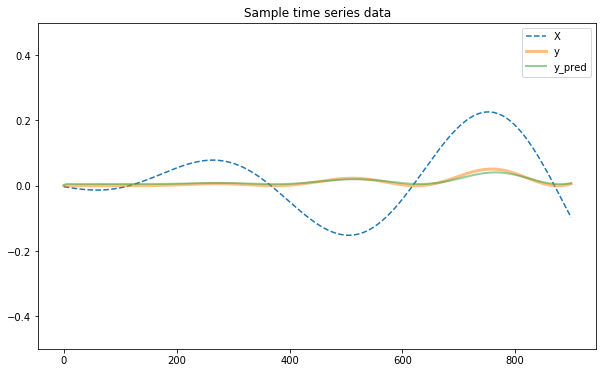

calling fit with X (500, 900, 1) and y (500, 900, 1)


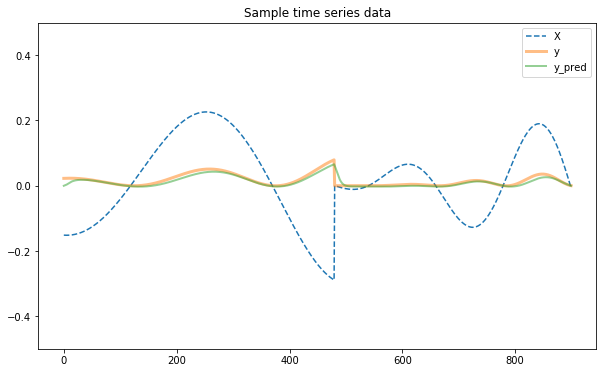

Time Took :2.53 min


In [7]:
ts = int(t_sample * 1.1)
n_batch = 500

training_points_generator = SampleDataPointsGenerator(ts)
training_online_to_batch_fit = OnlineToBatch(t_sample = t_sample, n_batch = n_batch)

start = time.time()

for i_point in range(3000):
    (training_X_point, training_y_point) = next(training_points_generator)
    (history, X_batch, y_batch) = training_online_to_batch_fit.process_point(model, training_X_point, training_y_point, action='fit', epochs=20, verbose=False)

    if history:
        # take first sample in the batch and get predicted y
        preds = model.predict(np.array([X_batch[0]]))[0]

        plot_sample((X_batch[0], y_batch[0], preds))
    
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


## Test the model

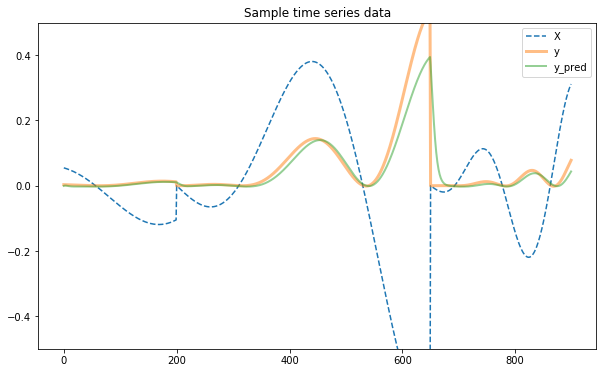

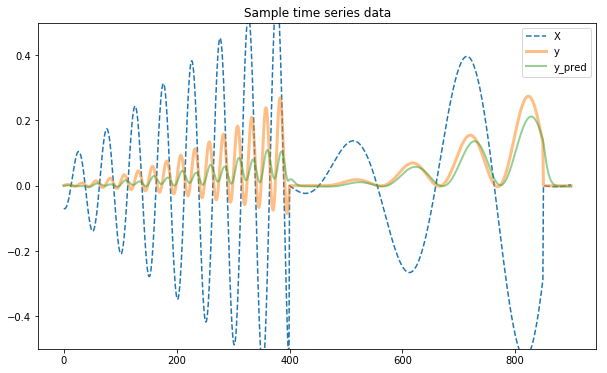

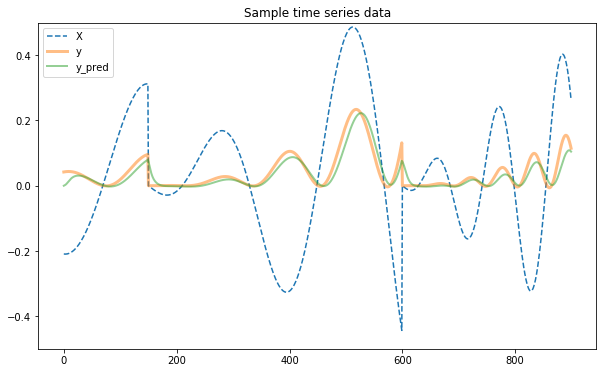

In [15]:
test_points_generator = SampleDataPointsGenerator(int(t_sample * 0.5))

for i in range(3):
    test_sample_X = []
    test_sample_y = []

    # skip some data
    for _ in range(2500):
        next(test_points_generator)

    for _ in range(t_sample):
        (X, y) = next(test_points_generator)
        test_sample_X.append(X)
        test_sample_y.append(y)

    preds = model.predict([[test_sample_X]])

    if preds is not None:
        plot_sample((np.array(test_sample_X), np.array(test_sample_y), preds[0]))




## Next steps

In this exercise, we generated some data, processed it sequentially one point as a time. `OnlineToBatch` crated batches of the data and trained the model. As seen above, test data produces reasonable predictions, which is a good enough sanity check for now.

Next, we will create `PseudoOnlineModel` subclass of LSTM model that will wrap `OnlineToBatch` logic. This new model type will be used as a building block in a larger predictive coding network.

Note: When training, $n_{batch}$ could start off small and grow asymptotically over time. This might allow a network to learn quickly during early volatile phase and to become stable later. Something to look into later.